In [1]:
import os
import time
import numpy as np
import pyfftw as ft
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

In [2]:
N = 1024
Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']

In [3]:
start = time.time()

u = np.zeros((N,N,N), dtype='float32')
v = np.zeros((N,N,N), dtype='float32')
w = np.zeros((N,N,N), dtype='float32')

end = time.time()
print(end-start)

0.000813961029053


In [4]:
start = time.time()

nproc = 8
nx = N//nproc

vx = np.zeros((N//nproc,N,N), dtype='float32')
vy = np.zeros((N//nproc,N,N), dtype='float32')
vz = np.zeros((N//nproc,N,N), dtype='float32')

folder = '/home/idies/workspace/scratch'

for k in range(nproc):
    filename = 'ref-isotropic1024coarse-'+str(k)+'-(t=0.0).npz'
    file = folder+'/'+filename
    
    content = np.load(file)
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    
    vx[:,:,:] = content['vx']
    vy[:,:,:] = content['vy']
    vz[:,:,:] = content['vz']
    
    u[k*nx:(k+1)*nx,:,:] = vx[:,:,:]
    v[k*nx:(k+1)*nx,:,:] = vy[:,:,:]
    w[k*nx:(k+1)*nx,:,:] = vz[:,:,:]

del vx,vy,vz
    
end = time.time()
print(end-start)

96.1014101505


In [5]:
urms = np.average(u**2 + v**2 + w**2)

In [6]:
start = time.time()

X = np.zeros((N,N,N))
Y = np.zeros((N,N,N))
Z = np.zeros((N,N,N))

Delta = isotropic1024coarse['dx']
for i in range(N):
    X[i,:,:] = i*Delta
    
for j in range(N):
    Y[:,j,:] = j*Delta
    
for k in range(N):
    Z[:,:,k] = k*Delta

end = time.time()
print(end-start)

143.44433713


In [7]:
start = time.time()

idxs = np.linspace(0,N**3,num=N**3,endpoint=False,dtype=int)
index = np.random.choice(idxs,N**2,replace=False)
jndex = np.random.choice(idxs,N**2,replace=False)

end = time.time()
print(end-start)

538.185581923


In [8]:
start = time.time()

x = X.flatten()
y = Y.flatten()
z = Z.flatten()

end = time.time()
print(end-start)

75.2492799759


In [10]:
dx = x[index] - x[jndex]
dy = y[index] - y[jndex]
dz = z[index] - z[jndex]

In [11]:
dx[dx<0.] = - dx[dx<0.]; dx[dx > np.pi] = 2*np.pi - dx[dx > np.pi]
dy[dy<0.] = - dy[dy<0.]; dy[dy > np.pi] = 2*np.pi - dy[dy > np.pi]
dz[dz<0.] = - dz[dz<0.]; dz[dz > np.pi] = 2*np.pi - dz[dz > np.pi]

In [12]:
r2 = dx**2 + dy**2 + dz**2 
r2rt = np.sqrt(r2)

In [13]:
nbins = 100; minrt = 0.; maxrt = np.pi*np.sqrt(3) 
bins = np.linspace(minrt,maxrt,num=nbins,endpoint=True)

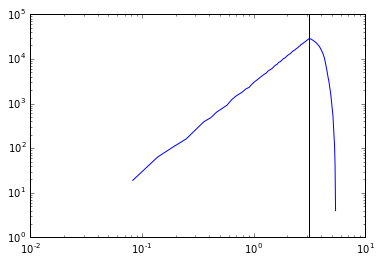

In [14]:
hist,edges = np.histogram(r2rt,bins=bins)
pbins = (edges[0:nbins-1]+edges[1:nbins])/2
plt.loglog(pbins,hist)
plt.axvline(x=np.pi,color='k')

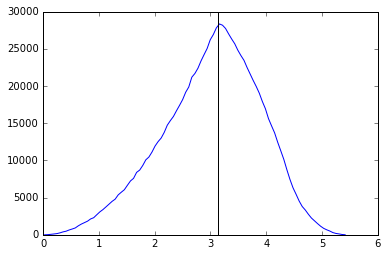

In [ ]:
plt.plot(pbins,hist)
plt.axvline(x=np.pi,color='k')

In [ ]:
u = u.flatten()
v = v.flatten()
w = w.flatten()

In [25]:
ui = u[index]; vi = v[index]; wi = w[index]
uj = v[jndex]; vj = v[jndex]; wj = w[jndex]

In [26]:
du = ui-uj; dv = vi-vj; dw = wi-wj

In [27]:
dx = x[index]-x[jndex]; dy = y[index]-y[jndex]; dz = z[index]-z[jndex];

In [28]:
r2ref = dx**2+dy**2+dz**2
r2ref = np.sqrt(r2ref)

In [ ]:
print(dx/r2ref,dy/r2ref,dz/r2ref)

In [ ]:
du_L = (du*dx + dv*dy + dw*dz)/r2ref

In [53]:
nbins = 1000; minrt = 0.; maxrt = np.pi*np.sqrt(3) 
bins = np.linspace(minrt,maxrt,num=nbins,endpoint=True)

rhist,redges = np.histogram(r2rt,bins=bins)
u1hist,u1redges = np.histogram(r2rt,bins=bins,weights=np.absolute(du_L))

/home/idies/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


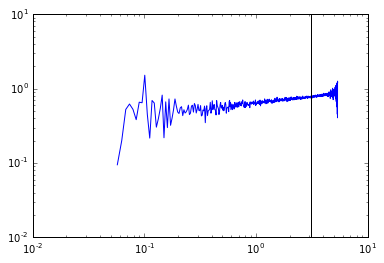

In [55]:
pbins = (redges[0:nbins-1]+redges[1:nbins])/2

plt.loglog(pbins,u1hist/rhist)
plt.axvline(x=np.pi,color='k')

In [56]:
nbins = 100; minrt = 0.; maxrt = np.pi*np.sqrt(3) 
bins = np.linspace(minrt,maxrt,num=nbins,endpoint=True)

rhist,redges = np.histogram(r2rt,bins=bins)
u2hist,u2redges = np.histogram(r2rt,bins=bins,weights=(du_L/urms)**2)

/home/idies/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


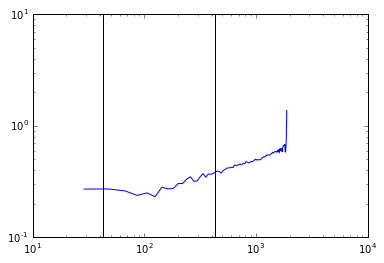

In [57]:
pbins = (edges[0:nbins-1]+edges[1:nbins])/2

eta = 0.00287

#plt.xlim((10**2,2*10**3))

plt.loglog(pbins/eta,u2hist/rhist)
plt.axvline(x=42.5,color='k')
plt.axvline(x=425,color='k')

In [58]:
brange = (pbins/eta>=42.5)&(pbins/eta<425.0)

In [59]:
print(brange.shape)


(99,)


In [60]:
print(pbins.shape,pbins[brange].shape,u2hist[brange].shape)

((99,), (20,), (20,))


In [61]:
fit = np.polyfit(np.log(pbins[brange]),np.log(u2hist[brange]/rhist[brange]),1)

In [62]:
print(fit[0])

0.216728312825
